# Amazon Fashion Category - Data Exploration

Category: Amazon Fashion
Team Member: Viktoriia Babii


## 1. Import Libraries


In [1]:
import os
from pathlib import Path
import warnings

import rootutils


rootutils.setup_root(Path.cwd(), indicator=".project-root", pythonpath=True)

ROOT_DIR = Path(os.environ.get("PROJECT_ROOT", Path.cwd()))
print(ROOT_DIR)

D:\big\amazon-reviews-analysis


In [2]:
import os
from pathlib import Path
import warnings

import rootutils


rootutils.setup_root(Path.cwd(), indicator=".project-root", pythonpath=True)

ROOT_DIR = Path(os.environ.get("PROJECT_ROOT", Path.cwd()))

REVIEWS_PATH = ROOT_DIR / "data/raw/review_categories/Amazon_Fashion.jsonl"
METADATA_PATH = ROOT_DIR / "data/raw/meta_categories/meta_Amazon_Fashion.jsonl"

warnings.filterwarnings("ignore")

## Initialize Spark


In [3]:
from src.amazon_reviews_analysis.utils import build_spark


spark = build_spark()

print("✓ Spark Session created successfully!")
print(f"Spark Version: {spark.version}")
print(f"Spark App Name: {spark.sparkContext.appName}")
print(f"Spark Master: {spark.sparkContext.master}")
print(f"Spark UI: {spark.sparkContext.uiWebUrl}")

✓ Spark Session created successfully!
Spark Version: 3.4.3
Spark App Name: AmazonReviews
Spark Master: local[*]
Spark UI: http://Viktoriia:4040


---

# PART A: METADATA

## Load Metadata


In [4]:
from src.amazon_reviews_analysis.utils import load_metadata


print(f"📂 Metadata: {METADATA_PATH}")

metadata_df = load_metadata(spark, METADATA_PATH)
print(f"Total records: {metadata_df.count():,}")

📂 Metadata: D:\big\amazon-reviews-analysis\data\raw\meta_categories\meta_Amazon_Fashion.jsonl
Total records: 826,108


## Schema & Structure


In [5]:
print("SCHEMA")
print("=" * 80)
metadata_df.printSchema()

print(f"\nColumns: {len(metadata_df.columns)}")
for idx, col_name in enumerate(metadata_df.columns, 1):
    print(f"{idx:2d}. {col_name}")


SCHEMA
root
 |-- author: struct (nullable = true)
 |    |-- about: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- avatar: string (nullable = true)
 |    |-- name: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- bought_together: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- description: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- details: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- features: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- hi_res: string (nullable = true)
 |    |    |-- large: string (nullable = true)
 |    |    |-- thumb: string (nullable = true)
 |    |    |-- variant: string (nullable = true)
 |-- main_category: string (

## Sample Data


In [6]:
metadata_df.show(5, truncate=50)

+------+--------------+---------------+----------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+--------------+-----------+-----+-------------+------------------+--------+--------------------------------------------------+--------------------------------------------------+
|author|average_rating|bought_together|categories|                                       description|                                           details|                                          features|                                            images| main_category|parent_asin|price|rating_number|             store|subtitle|                                             title|                                            videos|
+------+--------------+---------------+----------+--------------------------------------------------+-----------------------------------

The table describes the range of products from Amazon (from the fashion category), including ratings, specifications, brands, images, etc.

---

# PART B: REVIEWS

## Load Reviews


In [7]:
from src.amazon_reviews_analysis.utils import load_reviews

print(f"📂 Reviews: {REVIEWS_PATH}")

reviews_df = load_reviews(spark, REVIEWS_PATH)
print(f"Total records: {reviews_df.count():,}")

📂 Reviews: D:\big\amazon-reviews-analysis\data\raw\review_categories\Amazon_Fashion.jsonl
Total records: 2,500,939


## Schema & Structure


In [8]:
print("SCHEMA")
print("=" * 80)
reviews_df.printSchema()

print(f"\nColumns: {len(reviews_df.columns)}")
for idx, col_name in enumerate(reviews_df.columns, 1):
    print(f"{idx:2d}. {col_name}")

SCHEMA
root
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)


Columns: 10
 1. asin
 2. helpful_vote
 3. images
 4. parent_asin
 5. rating
 6. text
 7. timestamp
 8. title
 9. user_id
10. verified_purchase


## Sample Data


In [9]:
reviews_df.show(5, truncate=50)

+----------+------------+------+-----------+------+--------------------------------------------------+-------------+--------------------+----------------------------+-----------------+
|      asin|helpful_vote|images|parent_asin|rating|                                              text|    timestamp|               title|                     user_id|verified_purchase|
+----------+------------+------+-----------+------+--------------------------------------------------+-------------+--------------------+----------------------------+-----------------+
|B00LOPVX74|           3|    []| B00LOPVX74|   5.0|I think this locket is really pretty. The insid...|1578528394489|       Pretty locket|AGBFYI2DDIKXC5Y4FARTYDTQBMFQ|             true|
|B07B4JXK8D|           0|    []| B07B4JXK8D|   5.0|                                             Great|1608426246701|                   A|AFQLNQNQYFWQZPJQZS6V3NZU4QBQ|             true|
|B007ZSEQ4Q|           3|    []| B007ZSEQ4Q|   2.0|One of the stones fell o

The table contains information about user experiences, ratings, and comments about products. This data can be used to analyze sentiment, identify popular products, and correlate ratings with review text.

## DATA EXPLORATION
MISSING VALUES

In [10]:
from pyspark.sql.functions import col, sum, when, size

print("=== METADATA: Missing Values Analysis ===")
total_meta = metadata_df.count()

# % missed data in each column
nulls = metadata_df.select([
    (sum(when(col(c).isNull(), 1).otherwise(0)) / total_meta).alias(c)
    for c in metadata_df.columns
])

nulls.show(truncate=False)

metadata_df.select([
    (sum(when(size(col(c)) == 0, 1).otherwise(0)) / total_meta).alias(f"{c}_empty")
    for c in ["categories", "images", "description", "features"]
]).show(truncate=False)

=== METADATA: Missing Values Analysis ===
+------+--------------+---------------+----------+-----------+-------+--------+------+-------------+-----------+------------------+-------------+------------------+--------+-----+------+
|author|average_rating|bought_together|categories|description|details|features|images|main_category|parent_asin|price             |rating_number|store             |subtitle|title|videos|
+------+--------------+---------------+----------+-----------+-------+--------+------+-------------+-----------+------------------+-------------+------------------+--------+-----+------+
|1.0   |0.0           |1.0            |0.0       |0.0        |0.0    |0.0     |0.0   |0.0          |0.0        |0.9391738126249837|0.0          |0.0324872776925051|1.0     |0.0  |0.0   |
+------+--------------+---------------+----------+-----------+-------+--------+------+-------------+-----------+------------------+-------------+------------------+--------+-----+------+

+----------------+----


METADATA: metadata_df table has a significant number of gaps, especially in columns related to content (description, features, categories) and price.

In [11]:
print("=== REVIEWS: Missing Values Analysis ===")

total_reviews = reviews_df.count()

nulls = reviews_df.select([
    (sum(when(col(c).isNull(), 1).otherwise(0)) / total_reviews).alias(c)
    for c in reviews_df.columns
])
nulls.show()

=== REVIEWS: Missing Values Analysis ===
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
|asin|helpful_vote|images|parent_asin|rating|text|timestamp|title|user_id|verified_purchase|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+
| 0.0|         0.0|   0.0|        0.0|   0.0| 0.0|      0.0|  0.0|    0.0|              0.0|
+----+------------+------+-----------+------+----+---------+-----+-------+-----------------+



REVIEWS: reviews_df has high data quality — all fields are filled in. This means the data can be used for further analysis without any problems.

BASIC STATISTICS

In [12]:
metadata_df.describe().show()

+-------+------------------+---------------+--------------+--------------------+------------------+------------------+--------------------+--------+--------------------+
|summary|    average_rating|bought_together| main_category|         parent_asin|             price|     rating_number|               store|subtitle|               title|
+-------+------------------+---------------+--------------+--------------------+------------------+------------------+--------------------+--------+--------------------+
|  count|            826108|              0|        826108|              826108|             50249|            826108|              799270|       0|              826108|
|   mean| 3.910659502147479|           null|          null| 5.350344636264151E9| 40.79592927222482| 17.94220368281145|            Infinity|    null|6.337783713542857E10|
| stddev|0.9822820945302692|           null|          null|3.6015587199013114E9|154.08943482483937|221.79272967815186|                 NaN|    null|2.

METADATA: metadata_df shows that the products are mostly positively rated, but the spread in prices and number of ratings is large. The price ranges indicate the presence of both budget and premium brands.

In [13]:
reviews_df.describe().show()

+-------+--------------------+------------------+--------------------+------------------+------------+--------------------+-------+--------------------+
|summary|                asin|      helpful_vote|         parent_asin|            rating|        text|           timestamp|  title|             user_id|
+-------+--------------------+------------------+--------------------+------------------+------------+--------------------+-------+--------------------+
|  count|             2500939|           2500939|             2500939|           2500939|     2500939|             2500939|2500939|             2500939|
|   mean|3.1880700104324894E9|0.5658634616837915| 2.994439307599537E9| 3.969467468019012|    Infinity|1.543472511333768...|    NaN|                null|
| stddev|3.2868954040175943E9|3.7857617610757783|3.3515769293714943E9|1.4271711881829394|         NaN|7.101363536216295E10|    NaN|                null|
|    min|          0000099813|                 0|          0000099813|            

REVIEWS: Most users leave positive reviews, but there are a number of low ratings. The review texts are of varying lengths, sometimes even emojis.

The average rating for both products and reviews is ≈ 4, meaning positive ratings prevail.

The data varies by price, popularity, and publication period.

EXPLORATION OF SOME COLUMNS

In [14]:
reviews_df.groupBy("rating").count().orderBy("rating").show()

+------+-------+
|rating|  count|
+------+-------+
|   1.0| 303411|
|   2.0| 173462|
|   3.0| 245471|
|   4.0| 352327|
|   5.0|1426268|
+------+-------+



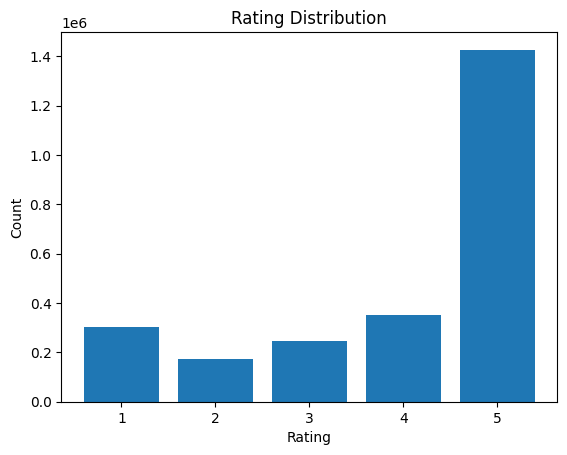

In [15]:
rating_counts = (
    reviews_df.groupBy("rating")
    .count()
    .orderBy("rating")
)

pdf = rating_counts.toPandas()

import matplotlib.pyplot as plt

plt.figure()
plt.bar(pdf["rating"], pdf["count"])
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


In [16]:
reviews_df.agg({'rating': 'avg'}).show()

+-----------------+
|      avg(rating)|
+-----------------+
|3.969467468019012|
+-----------------+



Most users give the highest rating — 5.0.

This indicates either general user satisfaction or a bias in ratings (people are more likely to leave reviews when they are very satisfied).

The fewest reviews have a rating of 2.0. Low ratings are less common, which is also a typical effect — dissatisfied users sometimes do not leave a review.

The distribution is asymmetric — clearly biased towards high ratings.

In [17]:
reviews_df.groupBy("verified_purchase").count().show()

+-----------------+-------+
|verified_purchase|  count|
+-----------------+-------+
|             true|2337702|
|            false| 163237|
+-----------------+-------+



Most reviews (>93%) are verified by purchase, i.e. left by users who actually purchased the product.

Only less than 7% are unverified, which could mean:

the user left the review without purchasing through another platform;

or potentially less reliable reviews (bots, advertising, subjective opinions).

In [18]:
from pyspark.sql.functions import length

reviews_df.select(length("text").alias("text_length")).describe().show() # description of review text lengths


+-------+------------------+
|summary|       text_length|
+-------+------------------+
|  count|           2500939|
|   mean|142.17913911534828|
| stddev|188.17510812168024|
|    min|                 0|
|    max|             13377|
+-------+------------------+



Text data is highly polarized by length. Most reviews are likely short (around 142 characters), but there is a significant number of anomalously long (up to 13k characters) and empty (0 characters) reviews, which makes the data "unstable" for analysis.

In [19]:
reviews_df.groupBy("user_id", "asin", "timestamp").count().orderBy("count", ascending=False).show(5) # potential duplicate or suspicious entries

+--------------------+----------+-------------+-----+
|             user_id|      asin|    timestamp|count|
+--------------------+----------+-------------+-----+
|AE22JJNSDFUJU4JXP...|B0169U8R40|1608149317130|    9|
|AGYWMOABBXZQ73ELM...|B07WLNSW9Y|1573173223589|    8|
|AE5FST5YZ4LJXGWJE...|B00MXFWI7I|1423343269000|    8|
|AH43RZ5L4GAJ2UPVN...|B083WKFBC4|1615486691588|    8|
|AFFTV4KQKMIBCOHQO...|B07KF6W15S|1567294325389|    8|
+--------------------+----------+-------------+-----+
only showing top 5 rows



The same user left several (up to 10) identical entries about the same product at the same time.

In [20]:
from pyspark.sql.functions import count

duplicates = reviews_df.groupBy("user_id", "asin", "timestamp").count().filter("count > 1")
print(duplicates.count())

21526


In [21]:
from pyspark.sql.functions import approx_count_distinct

reviews_df.select(
    approx_count_distinct("asin").alias("unique_products"),
    approx_count_distinct("user_id").alias("unique_users")
).show()

+---------------+------------+
|unique_products|unique_users|
+---------------+------------+
|         860489|     2145039|
+---------------+------------+



If we compare it to the total number of reviews (2.5 billion), we can conclude that on average one user leaves 1.17 reviews, and there are approximately 3 reviews per product.

In [22]:
print("=== Price Analysis ===")
metadata_df.filter(col("price").isNotNull()) \
    .select("price", "title", "average_rating") \
    .orderBy("price", ascending=False) \
    .show(10, truncate=50)


from pyspark.sql.functions import when
price_ranges = metadata_df.filter(col("price").isNotNull()) \
    .withColumn("price_range", 
        when(col("price") < 10, "Budget (<$10)")
        .when(col("price") < 25, "Mid ($10-25)")
        .when(col("price") < 50, "Premium ($25-50)")
        .otherwise("Luxury (>$50)")
    ) \
    .groupBy("price_range").count() \
    .orderBy("count", ascending=False)

price_ranges.show()

=== Price Analysis ===
+------+--------------------------------------------------+--------------+
| price|                                             title|average_rating|
+------+--------------------------------------------------+--------------+
|999.99|JYX Pearl Necklace Huge 12-15mm AAA White Pink ...|           5.0|
|998.99|Victorinox Men's 241741 Airboss Black Edition A...|           3.3|
| 995.0|Zodiac Men's Sea Dragon Deployant Swiss Automat...|           5.0|
| 99.99|Sterling Silver Studs Freshwater Cultured White...|           5.0|
| 99.99|     Men's White Formal Dinner Jacket - 52 Regular|           4.5|
| 99.99|                                 Nike Men's Jersey|           4.6|
| 99.99|Akoya Cultured Round Pearl Stud Womens Earrings...|           4.6|
| 99.99|American Heroes Men's 925 Sterling Silver Malte...|           5.0|
| 99.99|Titanium Kay Tungsten Carbide Brown Riverstone ...|           5.0|
| 99.99|adidas Men's Bayern Munich SSP Crewneck Sweatshirt|           4.3|
+-

The data covers a very wide price range, from budget to luxury goods.

The most popular price segment (10-25) is the majority of mid-range products.

A significant proportion of cheap goods.

Luxury goods are rare, but present in the sample.

In [23]:
from pyspark.sql.functions import avg

price_stats = metadata_df.filter(col("price").isNotNull()) \
    .withColumn("price_range", 
        when(col("price") < 10, "Budget (<$10)")
        .when(col("price") < 25, "Mid ($10-25)")
        .when(col("price") < 50, "Premium ($25-50)")
        .otherwise("Luxury (>$50)")
    ) \
    .groupBy("price_range") \
    .agg(
        count("*").alias("product_count"),
        avg("average_rating").alias("avg_rating")
    ) \
    .orderBy("avg_rating", ascending=False)

price_stats.show()

+----------------+-------------+-----------------+
|     price_range|product_count|       avg_rating|
+----------------+-------------+-----------------+
|   Luxury (>$50)|         7606|4.236444911911649|
|Premium ($25-50)|        11056|4.164688856729376|
|    Mid ($10-25)|        20882|4.141265204482329|
|   Budget (<$10)|        10705|4.042989257356375|
+----------------+-------------+-----------------+



In [24]:
numeric_cols = ["average_rating", "rating_number", "price"]

num_pdf = metadata_df.select(numeric_cols).toPandas()

corr = num_pdf.corr()
corr

,average_rating,rating_number,price
average_rating,1.000000,0.018287,0.029340
rating_number,0.018287,1.000000,-0.012644
price,0.029340,-0.012644,1.000000


The average rating is almost independent of price and number of reviews.

The conclusions of the previous analysis on price_range are confirmed: more expensive products receive slightly better ratings, but the overall dependence is weak.

## CONCLUSIONS
Data quality and completeness
There are many missing or empty values ​​in metadata_df.

There are no missing values ​​in reviews_df, the data is more structured and complete.

Basic statistics on goods
Average product rating: ~4, minimum 1, maximum 5.

Price ranges from 0.01 to 999.9.

main_category — Fashion

Data covers a wide range of prices and ratings.

Reviews analysis
Number of reviews: 2.5 billion

Most reviews are 5 stars, many are positive, fewer are negative.

Verified purchase: ~90% confirmed by purchase → most reviews are reliable.

Repeated entries by the same user for the same product at the same time were detected (up to 10 duplicates) → duplicate entries need to be cleaned.

Reviews are generally reliable, positive, but there are anomalies (repeated entries, empty texts) that should be removed before in-depth analysis.

Price analysis
More expensive products receive slightly higher ratings, but the overall relationship is weak (correlation ~0.023).

The bulk of products are budget and mid-range.

The correlation between price and rating is almost zero → price is not a strong factor for evaluation.

## DATA PREPARATION

In [25]:
print("DATA CLEANING - REVIEWS")

print("\n1. Checking for duplicates...")
print(f"Original count: {reviews_df.count():,}")

duplicates = reviews_df.groupBy("user_id", "asin", "timestamp") \
    .count() \
    .filter(col("count") > 1) \
    .orderBy(col("count").desc())

print(f"Duplicate groups found: {duplicates.count():,}")

DATA CLEANING - REVIEWS

1. Checking for duplicates...
Original count: 2,500,939
Duplicate groups found: 21,526


In [26]:
from pyspark.sql.functions import col, row_number
from pyspark.sql.window import Window

window_spec = Window.partitionBy("user_id", "asin", "timestamp") \
                    .orderBy("rating")  

reviews_cleaned = reviews_df.withColumn(
    "row_num",
    row_number().over(window_spec)
).filter(col("row_num") == 1).drop("row_num")

print(f"\nAfter removing duplicates: {reviews_cleaned.count():,}")


After removing duplicates: 2,475,694


In [27]:
from pyspark.sql.functions import col, length, trim

print("Checking for empty/invalid reviews...")

empty_text = reviews_cleaned.filter(
    (col("text").isNull()) | 
    (length(trim(col("text"))) == 0)
).count()

print(f"Reviews with empty text: {empty_text:,}")


reviews_cleaned = reviews_cleaned.filter(
    (col("text").isNotNull()) & 
    (length(trim(col("text"))) > 0)
)

print(f"After removing empty texts: {reviews_cleaned.count():,}")

Checking for empty/invalid reviews...
Reviews with empty text: 2,393
After removing empty texts: 2,473,301


In [28]:
print("\nChecking rating validity...")

invalid_ratings = reviews_cleaned.filter(
    (col("rating") < 1.0) | 
    (col("rating") > 5.0)
).count()

print(f"Invalid ratings (outside 1-5 range): {invalid_ratings}")


Checking rating validity...
Invalid ratings (outside 1-5 range): 0


In [29]:
print("DATA CLEANING - METADATA")

print("\nChecking metadata duplicates...")
print(f"Original count: {metadata_df.count():,}")

metadata_cleaned = metadata_df.dropDuplicates(["parent_asin"])

print(f"After removing duplicates: {metadata_cleaned.count():,}")
print(f"Removed: {metadata_df.count() - metadata_cleaned.count():,} duplicates")

DATA CLEANING - METADATA

Checking metadata duplicates...
Original count: 826,108
After removing duplicates: 826,108
Removed: 0 duplicates


In [30]:
print("\nChecking products without title...")

no_title = metadata_cleaned.filter(
    (col("title").isNull()) | 
    (length(trim(col("title"))) == 0)
).count()

print(f"Products without title: {no_title}")


Checking products without title...
Products without title: 58


In [31]:
metadata_cleaned = metadata_cleaned.filter(
    (col("title").isNotNull()) & 
    (length(trim(col("title"))) > 0)
)

In [32]:
print("\nChecking price anomalies...")

price_anomalies = metadata_cleaned.filter(col("price").isNotNull()) \
    .select("price", "title") \
    .orderBy("price")

price_anomalies.show(10, truncate=50)


Checking price anomalies...
+-----+--------------------------------------------------+
|price|                                             title|
+-----+--------------------------------------------------+
| 0.01|Clearance Deals Pendant Necklace Womens Natural...|
| 0.01|iLH Clearance Silicone Rubber Rings,Men's Engag...|
| 0.01|Red 1.5 inch Wide Snap Removable Buckle Belt Small|
| 0.01|iLH Clearance Deals Womens Handmade Heart Cryst...|
| 0.01|Clearance!! WYTong Ladies Religious Style Chain...|
| 0.01|Napoo Clearance 1Pair Women's Cute Camellia Buc...|
| 0.01|iLH Clearance Deals Opal Pendant Necklace Women...|
| 0.01|Unisex Punk Corselet Shape Rhinestone Joint Knu...|
| 0.01|Napoo Women Luxury Hollow Bright Colorful Rhine...|
| 0.01|Pet Shirt Small Dog Clothes USA Flag Jacquard P...|
+-----+--------------------------------------------------+
only showing top 10 rows



In [33]:
print("\nChecking invalid average ratings in metadata...")

invalid_avg = metadata_cleaned.filter(
    (col("average_rating") < 0) | 
    (col("average_rating") > 5)
).count()

print(f"Invalid average ratings: {invalid_avg}")


Checking invalid average ratings in metadata...
Invalid average ratings: 0


In [34]:
print("SAVING CLEANED DATA")

CLEANED_REVIEWS_PATH = ROOT_DIR / "data/raw/review_categories/all_beauty_reviews_cleaned.parquet"
CLEANED_METADATA_PATH = ROOT_DIR / "data/raw/meta_categories/all_beauty_metadata_cleaned.parquet"

reviews_cleaned.write.mode("overwrite").parquet(str(CLEANED_REVIEWS_PATH))
metadata_cleaned.write.mode("overwrite").parquet(str(CLEANED_METADATA_PATH))

print(f"Cleaned reviews saved to: {CLEANED_REVIEWS_PATH}")
print(f"Cleaned metadata saved to: {CLEANED_METADATA_PATH}")

print("\nFINAL STATISTICS:")
print(f"Reviews: {reviews_df.count():,} → {reviews_cleaned.count():,}")
print(f"Metadata: {metadata_df.count():,} → {metadata_cleaned.count():,}")
print(f"Total records removed: {(reviews_df.count() - reviews_cleaned.count()) + (metadata_df.count() - metadata_cleaned.count()):,}")

SAVING CLEANED DATA
Cleaned reviews saved to: D:\big\amazon-reviews-analysis\data\raw\review_categories\all_beauty_reviews_cleaned.parquet
Cleaned metadata saved to: D:\big\amazon-reviews-analysis\data\raw\meta_categories\all_beauty_metadata_cleaned.parquet

FINAL STATISTICS:
Reviews: 2,500,939 → 2,473,301
Metadata: 826,108 → 826,050
Total records removed: 27,696
